# Projet 6 :

# Data augmentation

### Chargement des bibliothèques et des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

2023-06-24 23:54:02.189673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Chargement des données df
image_df = pd.read_csv('image_df.csv')
image_df

,ImagePath,categorie,label
0,/Users/azizi/Desktop/Flipkart/Images/55b85ea15...,Home Furnishing,4
1,/Users/azizi/Desktop/Flipkart/Images/7b72c92c2...,Baby Care,0
2,/Users/azizi/Desktop/Flipkart/Images/64d5d4a25...,Baby Care,0
3,/Users/azizi/Desktop/Flipkart/Images/d4684dcdc...,Home Furnishing,4
4,/Users/azizi/Desktop/Flipkart/Images/6325b6870...,Home Furnishing,4
...,...,...,...
1045,/Users/azizi/Desktop/Flipkart/Images/958f54f4c...,Baby Care,0
1046,/Users/azizi/Desktop/Flipkart/Images/fd6cbcc22...,Baby Care,0
1047,/Users/azizi/Desktop/Flipkart/Images/5912e037d...,Baby Care,0
1048,/Users/azizi/Desktop/Flipkart/Images/c3edc504d...,Baby Care,0


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def create_model():
    # Charger le modèle pré-entraîné VGG16 sans les couches supérieures (entièrement connectées)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Geler les couches du modèle de base pour empêcher leur entraînement
    for layer in base_model.layers:
        layer.trainable = False

    # Créer un nouveau modèle séquentiel au-dessus du modèle de base
    model = models.Sequential()

    # Ajouter le modèle de base VGG16
    model.add(base_model)

    # Aplatir les sorties en un vecteur 1D
    model.add(layers.Flatten())

    # Ajouter une couche Dense avec 512 neurones et activation ReLU
    model.add(layers.Dense(512, activation='relu'))

    # Appliquer la régularisation Dropout avec un taux de 0.5
    model.add(layers.Dropout(0.5))

    # Ajouter une autre couche Dense avec 256 neurones et activation ReLU
    model.add(layers.Dense(256, activation='relu'))

    # Appliquer à nouveau la régularisation Dropout avec un taux de 0.5
    model.add(layers.Dropout(0.5))

    # Ajouter la couche de sortie Dense avec 7 neurones pour la classification (activation softmax)
    model.add(layers.Dense(7, activation='softmax')) 

    # Compiler le modèle avec l'optimiseur RMSprop, une faible valeur d'apprentissage (lr=1e-3), 
    # la fonction de perte categorical_crossentropy et la métrique d'évaluation accuracy
    model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Afficher un résumé détaillé du modèle, montrant l'architecture et le nombre de paramètres entraînables
    model.summary()

    return model


In [4]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement, de validation et de test
train_df, val_test_df = train_test_split(image_df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, shuffle=True)

In [5]:
train_df.head()

,ImagePath,categorie,label
554,/Users/azizi/Desktop/Flipkart/Images/b144a363c...,Watches,6
1012,/Users/azizi/Desktop/Flipkart/Images/29def171d...,Home Decor & Festive Needs,3
481,/Users/azizi/Desktop/Flipkart/Images/9f9bb0ef3...,Computers,2
432,/Users/azizi/Desktop/Flipkart/Images/7f2f1f303...,Computers,2
626,/Users/azizi/Desktop/Flipkart/Images/73901494e...,Home Furnishing,4


In [6]:
val_df.shape

(105, 3)

In [7]:
test_df.shape

(105, 3)

In [8]:
# Set up data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.25,
                                   preprocessing_function=preprocess_input)

#ImageDataGenerator(rescale=1./255,
                              #     rotation_range=40,
                               #    width_shift_range=0.2,
                                #   height_shift_range=0.2,
                                 #  shear_range=0.2,
                                  # zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)#rescale=1./255)


In [9]:
# Create generators from the DataFrames
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='ImagePath',
        y_col='categorie',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='ImagePath',
        y_col='categorie',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 840 validated image filenames belonging to 7 classes.
Found 105 validated image filenames belonging to 7 classes.


In [10]:
# Création du modèle
with tf.device('/gpu:0'): 
    model = create_model()

# Création du callback
model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1

## Optimisation des hyperparamètres 

In [11]:
with tf.device('/gpu:0'):
    history = history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // 32,
        epochs=50,
        validation_data=val_generator,
        validation_steps=val_generator.samples // 32, verbose=1)

Epoch 1/50


2023-06-24 23:54:12.291623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - ETA: 0s - loss: 37.3690 - accuracy: 0.4158

2023-06-24 23:58:24.544894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 285s 11s/step - loss: 37.3690 - accuracy: 0.4158 - val_loss: 5.0471 - val_accuracy: 0.7812
Epoch 2/50
26/26 [==============================] - 279s 11s/step - loss: 13.7202 - accuracy: 0.5730 - val_loss: 4.8688 - val_accuracy: 0.7500
Epoch 3/50
26/26 [==============================] - 275s 11s/step - loss: 11.3951 - accuracy: 0.5842 - val_loss: 5.1966 - val_accuracy: 0.7396
Epoch 4/50
26/26 [==============================] - 276s 11s/step - loss: 9.1593 - accuracy: 0.6436 - val_loss: 4.6340 - val_accuracy: 0.8125
Epoch 5/50
26/26 [==============================] - 275s 11s/step - loss: 6.5698 - accuracy: 0.6881 - val_loss: 3.4878 - val_accuracy: 0.7812
Epoch 6/50
26/26 [==============================] - 276s 11s/step - loss: 7.0819 - accuracy: 0.6720 - val_loss: 3.4103 - val_accuracy: 0.8333
Epoch 7/50
26/26 [==============================] - 274s 11s/step - loss: 5.3473 - accuracy: 0.7265 - val_loss: 3.9030 - val_accuracy: 0.7604
Epoch 8/50
26/

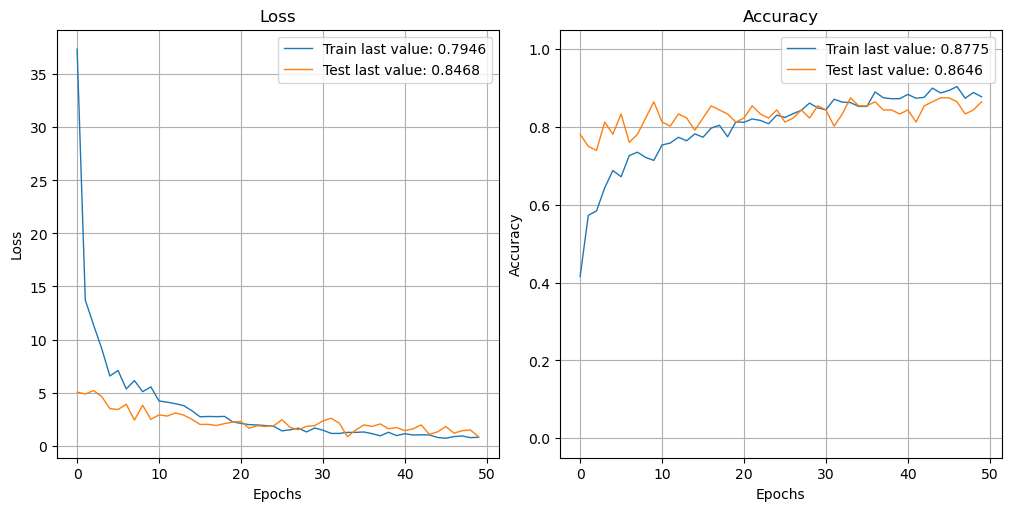

In [12]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()